In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ephem
import math
from datetime import timedelta
import matplotlib.dates as mdates
import glob
from scipy.stats import pearsonr

In [2]:
def calculate_solar_cos_zenith(datetime_obj):
    observer = ephem.Observer()
    latitude  = 38.980762    # ERW
    longitude = -107.005017  # ERW
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

In [3]:
qcrad = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*cdf")

/global/homes/r/rudisill/.conda/envs/xenv/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [29]:
kolias = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/kollias/cbh_kolias2.nc").to_pandas()
cloud_present_kolias = kolias.copy()
cloud_present_kolias[cloud_present_kolias == -1] = 0
cloud_present_kolias[(cloud_present_kolias < 6000) & (cloud_present_kolias >0)] = 1
cloud_present_kolias[cloud_present_kolias >= 6000] = 0


In [5]:
cbh = cloud_present_kolias.cloud_base_best_estimate.resample("1min").mean()

In [6]:
met=xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/gucmet/all_met.nc")

In [7]:
t2m = met.temp_mean.where(met.qc_temp_mean==0).to_pandas()

In [8]:
q2m = met.vapor_pressure_mean.where(met.qc_vapor_pressure_mean==0).to_pandas()

In [9]:
ulw = qcrad.up_long_hemisp.where(qcrad.qc_up_long_hemisp==0).to_pandas()

In [10]:
# let's look at the clear sky albedo.. 
qcswd = qcrad.BestEstimate_down_short_hemisp.where(qcrad.qc_BestEstimate_down_short_hemisp==0)
qcswu = qcrad.up_short_hemisp.where(qcrad.qc_up_short_hemisp==0)
albedo = (qcswu / qcswd).to_pandas()

In [11]:
# make a big dataframe 
df = pd.DataFrame({"ulw":ulw})

In [12]:
df['t2m']= t2m.reindex(df.index)
df['q2m']= q2m.reindex(df.index)
df['cbh']= cbh.reindex(df.index)

In [13]:
df['cza'] = df.index.map(calculate_solar_cos_zenith)

In [14]:
df['albedo'] = albedo.reindex(df.index)

In [15]:
df_no_cloud = df[df.cbh <.1]

In [16]:
df_no_cloud = df_no_cloud.dropna()

In [17]:
### now do xgboost 
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X = df_no_cloud[['t2m', 'q2m', 'cza', 'albedo']].values  # Replace with your actual independent variables
y = df_no_cloud['ulw'].values # Replace with your actual dependent variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


params = {
    "n_estimators": 100,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))



The mean squared error (MSE) on test set: 56.9197


In [18]:
def bias(y, y_pred):
    return np.mean(y - y_pred)


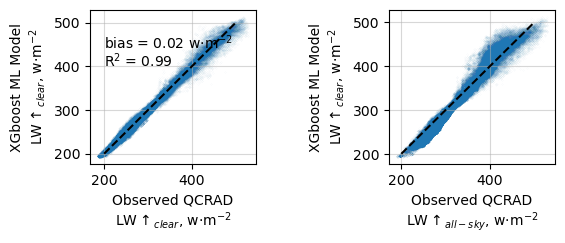

In [19]:
fig, ax = plt.subplots(1,2, figsize=(6,2))
ax[0].scatter(y_test, reg.predict(X_test), s=.01, alpha=.1)
ax[0].set_xlabel("Observed QCRAD\n" + r"LW$\uparrow_{clear}$, w$\cdot$m$^{-2}$")
ax[0].set_ylabel("XGboost ML Model\n" + r"LW$\uparrow_{clear}$, w$\cdot$m$^{-2}$")
ax[0].plot([200, 500], [200, 500], color='black', linestyle='--')


# now make the prediction for cloudy periods 
df_with_cloud = df[df.cbh >.1].dropna()
X_cloud = df_with_cloud[['t2m', 'q2m', 'cza', 'albedo']].values 
y_cloud = df_with_cloud[['ulw']]


ax[1].scatter(y_cloud, reg.predict(X_cloud), s=.01, alpha=.1)
ax[1].set_xlabel("Observed QCRAD\n" + r"LW$\uparrow_{all-sky}$, w$\cdot$m$^{-2}$")
ax[1].set_ylabel("XGboost ML Model\n" + r"LW$\uparrow_{clear}$, w$\cdot$m$^{-2}$")
ax[1].plot([200, 500], [200, 500], color='black', linestyle='--')
ax[1].grid(True, alpha=.5)
ax[0].grid(True, alpha=.5)
plt.subplots_adjust(wspace=.8)



ax[0].text(200, 400, "R$^2$ = {:.2f}".format(pearsonr(y_test, reg.predict(X_test))[0]**2))
ax[0].text(200, 440, "bias = {:.2f}".format(bias(y_test, reg.predict(X_test))) + r" w$\cdot$m$^{-2}$")
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_Figure_X_lw_up_model", dpi=300, bbox_inches="tight")



In [20]:
X_day_with_cloud = df_with_cloud[['t2m', 'q2m', 'cza', 'albedo']].where(df_with_cloud.cza>0).dropna()
X_night_with_cloud = df_with_cloud[['t2m', 'q2m', 'cza', 'albedo']].where(df_with_cloud.cza<0).dropna()


/global/homes/r/rudisill/.conda/envs/xenv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
/global/homes/r/rudisill/.conda/envs/xenv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


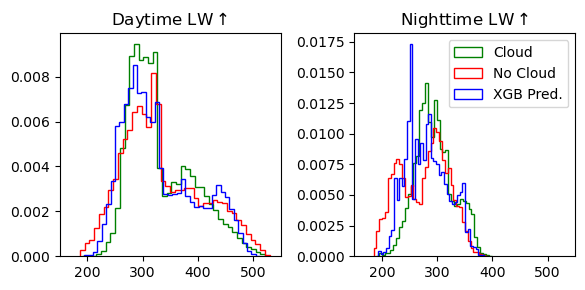

In [21]:
#_=plt.hist(reg.predict(X_cloud), bins=40, histtype='step', density=True)
#_=plt.hist(reg.predict(X), bins=40, histtype='step', density=True)

fig, ax = plt.subplots(1,2, figsize=(6,3))
_=ax[0].hist(df_with_cloud.ulw.where(df_with_cloud.cza>0).dropna(), bins=40, histtype='step', density=True, color='green', label='Cloud')
_=ax[0].hist(df_no_cloud.ulw.where(df_no_cloud.cza>0).dropna(), bins=40, histtype='step', density=True, color='red', label='No Cloud')
_=ax[0].hist(reg.predict(X_day_with_cloud), bins=40, histtype='step', density=True, color='blue', label='XGB Pred.')



_=ax[1].hist(df_with_cloud.ulw.where(df_with_cloud.cza<0).dropna(), bins=40, histtype='step', density=True, color='green', label='Cloud')
_=ax[1].hist(df_no_cloud.ulw.where(df_no_cloud.cza<0).dropna(), bins=40, histtype='step', density=True, color='red', label='No Cloud')
_=ax[1].hist(reg.predict(X_night_with_cloud), bins=40, histtype='step', density=True, color='blue', label='XGB Pred.')



ax[0].set_title(r"Daytime LW$\uparrow$")
ax[1].set_title(r"Nighttime LW$\uparrow$")
ax[1].legend()
plt.tight_layout()
for axx in ax.flatten():
    axx.set_xlim(150, 550)


In [22]:
df

,ulw,t2m,q2m,cbh,cza,albedo
time,,,,,,
2021-09-01 00:00:00,419.688812,22.530001,0.559,NaN,0.316518,0.171444
2021-09-01 00:01:00,419.016205,22.590000,0.549,NaN,0.313312,0.171684
2021-09-01 00:02:00,418.308685,22.500000,0.591,NaN,0.310103,0.172136
2021-09-01 00:03:00,417.330994,22.410000,0.577,NaN,0.306890,0.173450
2021-09-01 00:04:00,416.587402,22.400000,0.558,NaN,0.303673,0.174474
...,...,...,...,...,...,...
2023-06-15 23:55:00,371.987396,10.290000,0.765,1.0,0.474819,0.166180
2023-06-15 23:56:00,371.146912,10.100000,0.764,1.0,0.471867,0.164341
2023-06-15 23:57:00,371.062408,10.040000,0.778,1.0,0.468910,0.162614


In [23]:
#df_no_na = df.dropna()
df = df[['t2m', 'q2m', 'cza', 'albedo','ulw']].dropna()
df['ulw_clear']= reg.predict(df[['t2m', 'q2m', 'cza', 'albedo']].values)

Text(0.5, 1.0, 'hourly mean LW$\\uparrow$ difference\n all-sky - clear')

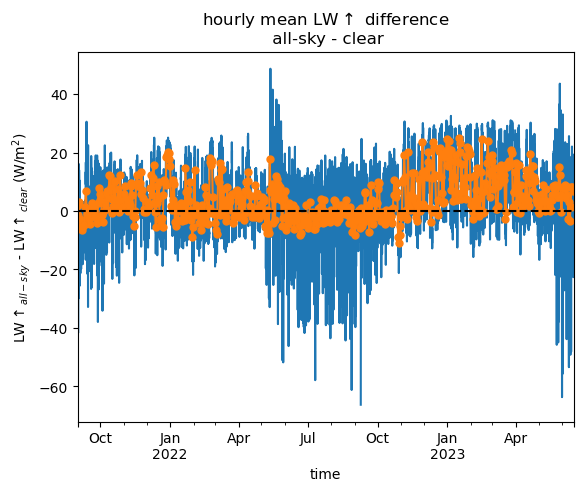

In [24]:
fig, ax = plt.subplots()
(df['ulw'] - df['ulw_clear']).resample("1h").mean().plot()
(df['ulw'] - df['ulw_clear']).resample("1d").mean().plot(marker='o', markersize=5)
ax.axhline(0, linestyle='--', color='black')
ax.set_ylabel(r"LW$\uparrow_{all-sky}$ - LW$\uparrow_{clear}$ (W/m$^2$)")
ax.set_title(r"hourly mean LW$\uparrow$ difference" + "\n all-sky - clear")

,cloud_base_best_estimate
time,
2021-09-14 00:00:00,0.0
2021-09-14 00:00:04,0.0
2021-09-14 00:00:08,0.0
2021-09-14 00:00:12,0.0
2021-09-14 00:00:16,0.0
...,...
2023-06-15 23:59:40,1.0
2023-06-15 23:59:44,1.0
2023-06-15 23:59:48,1.0


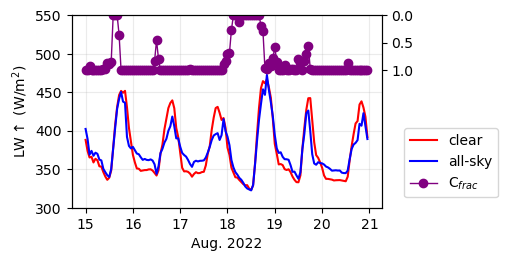

In [89]:
fig,ax=plt.subplots(figsize=(4, 2.5))
ax2 = ax.twinx()

timeind = df.resample("1h").mean()['2022-08-15':'2022-08-20'].index


ln1 = ax.plot(timeind, df.resample("1h").mean()['ulw_clear']['2022-08-15':'2022-08-20'] ,label='clear', color='red')
ln2 = ax.plot(timeind, df.resample("1h").mean()['ulw']['2022-08-15':'2022-08-20'], label='all-sky', color='blue')
ln3 = ax2.plot(timeind, cloud_present_kolias.resample("1h").mean()['2022-08-15':'2022-08-20'], color='purple', marker='o', linewidth=1, label=r'C$_{frac}$', zorder=0)


ax2.set_ylim(3.5, 0)
ax.set_ylim(300,550)


lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(1.05, .45), loc='upper left')

ax2.set_yticks([0,.5,1])


major_formatter = mdates.DateFormatter('%d')                      # Format major ticks as 'YYYY-MM-DD'
#ax.xaxis.set_major_locator(major_locator)
#ax.xaxis.set_minor_locator(minor_locator)
ax.xaxis.set_major_formatter(major_formatter)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_horizontalalignment('center')
    tick.label1.set_rotation('horizontal')
ax.grid(alpha=.25, which='both')

ax.set_xlabel("Aug. 2022")
ax.set_ylabel(r"LW$\uparrow$ (W/m$^2$)")
plt.savefig("/global/homes/r/rudisill/gshare2/will_data/cre_project_images/Supp_Figure_X_lw_up_model_aug_example", dpi=300, bbox_inches="tight")


In [67]:
help(mdates.MinuteLocator)

Help on class MinuteLocator in module matplotlib.dates:

class MinuteLocator(RRuleLocator)
 |  MinuteLocator(byminute=None, interval=1, tz=None)
 |  
 |  Make ticks on occurrences of each minute.
 |  
 |  Method resolution order:
 |      MinuteLocator
 |      RRuleLocator
 |      DateLocator
 |      matplotlib.ticker.Locator
 |      matplotlib.ticker.TickHelper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, byminute=None, interval=1, tz=None)
 |      Parameters
 |      ----------
 |      byminute : int or list of int, default: all minutes
 |          Ticks will be placed on every minutes in *byminutes*. Default is
 |          ``byminute=range(60)``, i.e., every minute.
 |      interval : int, default: 1
 |          The interval between each iteration. For example, if
 |          ``interval=2``, mark every second occurrence.
 |      tz : str or `~datetime.tzinfo`, default: :rc:`timezone`
 |          Ticks timezone. If a string, *tz* is passed to `dateutil

In [58]:
### SAVE THE DATA

In [25]:
#df.to_csv("/global/homes/r/rudisill/gshare2/will_data/crf_files/lw_up_clear_xgb.csv")